# PCA reduction example
For the following example, we will perform PCA using the givens transform. PCA seeks to find the orthonormal projection of data such that the projected data's variance is maximized. Hence finding the orthonormal projection matrix is an optimizaion problem. We shall begin by importing relevant libraries. 

In [22]:
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from givens import transform
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

We will need 2 utilities. Firstly, we need to define the PCA objective as a function of theta. Note that the givens transform function takes 2 arguments: The theta array (flattened array) and the shape of the stiefel manifold as a tuple.
Secondly, we need a utility to generate training data. In this example we will be drawing samples from a mutivariate normal distribution with mean 0 and a preselected covariance matrix.

In [23]:
'''
pca objective function. Theta is a flattened array, cov is an DxD covariance matrix, and shape is a tuple that specifies
the shape of the desired orthonormal matrix.
'''
def pca_objective(theta,cov,shape):
    U = transform(theta,shape)
    return -np.trace(np.dot(U.T,np.dot(cov,U)))

'''
Utilitie to draw 3D samples from a multivariate normal distibution with mean 0 and predefined covariance
'''
def generate_data(N=100):
    cov = np.array([[1.0,0.8,0.3],[0.8,2.,0.2],[0.3,0.2,1.1]])
    x = np.random.multivariate_normal(np.zeros(3),cov,size=N)
    return x

We will be trying to find the first principal component using 1000 training points.

In [24]:
#set constants
N=1000                 # Number of training points
D = 3                  # Dimensionality of training points
components = 1         # Number of PCA components
shape = (D,components) # shape of desired orthonormal matrix
dof = int(D*components-0.5*components*(components+1))  # Degrees of freedom of Stiefel Manifold

# generate data
x = generate_data(N)

#center data
x = x-np.mean(x,axis=0)

#compute covariance
cov = (1.0/N)*np.dot(x.T,x)

We wil now initialize theta and optimize the objective function. Once the optimal theta is found we will transform it back
to its corresponding orthonormal representation.

In [25]:
# initialize theta such that the steifel manifold is the unit vector along x1 
theta = np.zeros(dof)

# propagates gradients
g = grad(pca_objective)

# Optimize pca_objective with respect to theta
opt = minimize(pca_objective,theta,method='BFGS',jac=g,args=(cov,shape),options={'gtol':1e-12})

# convert optimal theta to stiefel equivalent
U = transform(opt['x'],shape)

We will now obtain 3D coordinates of the optimized projection line and plot the training points along with it.

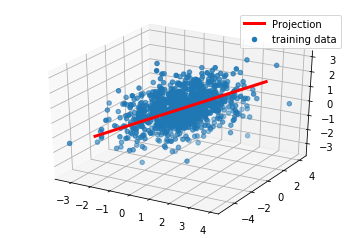

In [26]:
# get projection line and plot
x_proj = np.arange(-5,6)
x_proj = (U*x_proj).T

# Plot training points along with the projection line
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],label='training data')
ax.plot(x_proj[:,0],x_proj[:,1],x_proj[:,2],c='r',lw=3,label='Projection')
ax.legend()

We can see that the projection line corresponds to the direction of maximal variance in the data. We can now compare our optimized solution to the closed form solution obtained by eigendecomposition. 

In [17]:
# Obtain closed for solution by performing eigendecomposition
e,q = np.linalg.eigh(cov)

U_closed = q[:,-components:][:,::-1]
print('Closed form solution is given as: \n', U_closed)
print('Optimized solution is found as: \n', U)

Closed form solution is given as: 
 [[-0.49035678]
 [-0.86076885]
 [-0.13648153]]
Optimized solution is found as: 
 [[0.49035678]
 [0.86076885]
 [0.13648153]]


We can see that both solutions are identical (negating sign differences which are irrelevant). Note that the standard objective function of PCA does NOT have unique solutions due to rotational invariance. To see this, we will now perform PCA with 2 components. With 1 component, we do not experience the effect of rotational invariance.

# 2 Components PCA reduction
We will now perform the exact same steps but use 2 PCA components instead of 1, hence we are looking for the plane that maximizes the variance of the projected data.

In [27]:
#set constants
N=1000                 # Number of training points
D = 3                  # Dimensionality of training points
components = 2         # Number of PCA components
shape = (D,components) # shape of desired orthonormal matrix
dof = int(D*components-0.5*components*(components+1))  # Degrees of freedom of Stiefel Manifold

# generate data
x = generate_data(N)

#center data
x = x-np.mean(x,axis=0)

#compute covariance
cov = (1.0/N)*np.dot(x.T,x)

# initialize theta such that the steifel manifold is the unit vector along x1 
theta = np.zeros(dof)

# propagates gradients
g = grad(pca_objective)

# Optimize pca_objective with respect to theta
opt = minimize(pca_objective,theta,method='BFGS',jac=g,args=(cov,shape),options={'gtol':1e-12})

# convert optimal theta to stiefel equivalent
U = transform(opt['x'],shape)

We can now plot the training data along with the discovered projection plane. Notice that the rotational invariance is due to the fact that we can rotate the plan along its perpendicular axis to obtain the same exact projection plane.

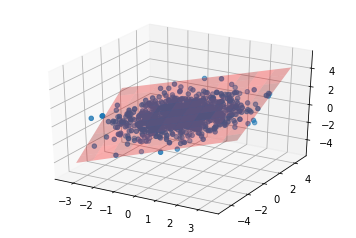

In [28]:
# get the projection plane
x_proj1 = np.arange(-5,6)
x_proj1 = (U[:,:1]*x_proj1).T
x_proj2 = np.arange(-5,6)
x_proj2 = (U[:,1:]*x_proj2).T

xproj = x_proj1+x_proj2[0]
for i in range(1,11):
    xproj = np.vstack((xproj,x_proj1+x_proj2[i]))
    
# Plot training points along with the projection line
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],label='training data')
ax.plot_surface(xproj[:,0].reshape(11,11),xproj[:,1].reshape(11,11),xproj[:,2].reshape(11,11),color='r',alpha=0.3,label='Projection')


We can now compare the obtained solution with the closed for solution, and we will notice that the solutions do not match... however the geometrical orientations of the planes themselves do in fact match up.

In [29]:
# Obtain closed for solution by performing eigendecomposition
e,q = np.linalg.eigh(cov)
U_closed = q[:,-components:][:,::-1]
print('Closed form solution is given as: \n', U_closed)
print('Optimized solution is found as: \n', U,end='\n\n')

Closed form solution is given as: 
 [[-0.47634744  0.13724266]
 [-0.85471864 -0.30400303]
 [-0.20627447  0.94273358]]
Optimized solution is found as: 
 [[ 0.26330826  0.42001332]
 [-0.05645518  0.90541406]
 [ 0.96305845 -0.06175915]]



In [35]:
%%latex 
We now want to explain the mismatch. Hence we will find the transformation matrix that turns $\boldsymbol{U}$ into $\boldsymbol{U}_{closed}$, ie we will solve
the system of equations $\boldsymbol{U}\boldsymbol{T}=\boldsymbol{U}_{closed}$ for $\boldsymbol{T}$. What we will notice is that $\boldsymbol{T}$ corresponds exactly
to a rotation matrix! Hence the rotation invariance of the solution.

<IPython.core.display.Latex object>

In [37]:
# Find the matrix T such that UT = U_closed 
T = np.linalg.lstsq(U,U_closed,rcond=None)[0]

# Assuming this is a rotation matrix, compute the angle and confirm this is indeed a rotation
angle = np.arccos(T[0,0])
rotation = np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]])
print('T matrix found as: \n', T)
print('rotation matrix associated with an angle of ', np.round(angle,4), ' rad : \n', rotation)


T matrix found as: 
 [[-0.27582729  0.96120721]
 [-0.96120721 -0.27582729]]
rotation matrix associated with an angle of  1.8502  rad : 
 [[-0.27582729  0.96120721]
 [-0.96120721 -0.27582729]]


In [40]:
%%latex
We will now go a step further and solve the problem in the traditional sense by peforming an actual constrained optimization 
without the givens transforms. We will use Pymanopt which is a manifold optimization library which easily allows us to optimize
objective functions on different types of manifolds. We shall call the solution found with Pymanopt as $\boldsymbol{U}_{opt}$.

<IPython.core.display.Latex object>

In [38]:
#Take a step further and solve the problem using a pymanopt to solve the optimization as a constrained problem
from pymanopt import Problem
from pymanopt.solvers import ConjugateGradient
from pymanopt.manifolds import Stiefel

# define objective function
def pca_objective(U):
    return -np.trace(np.dot(U.T,np.dot(cov,U)))

# set up Pymanopt problem and solve.
solver = ConjugateGradient(maxiter=1000)
manifold = Stiefel(D,components)
problem = Problem(manifold=manifold, cost=pca_objective, verbosity=0)
Uopt = solver.solve(problem)

print('Solution found using Pymanopt = \n', Uopt,end='\n\n')

Solution found using Pymanopt = 
 [[-0.49058231 -0.07121459]
 [-0.65353981 -0.62916421]
 [-0.5763807   0.77400315]]



In [42]:
%%latex
We notice that the solution does not match with either the closed form solution or the solution using givens transform.
Once more we will see if $\boldsymbol{U}_{opt}$ corresponds to a rotation of $\boldsymbol{U}_{closed}$.

<IPython.core.display.Latex object>

In [43]:
# Find the matrix T such that UA = Uopt 
T = np.linalg.lstsq(U,Uopt,rcond=None)[0]

# Assuming this is a rotation matrix, compute the angle and confirm this is indeed a rotation
angle = np.arccos(T[0,0])
rotation = np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]])
print('T matrix found as: \n', T)
print('rotation matrix associated with an angle of ', np.round(angle,4), ' rad : \n', rotation)

T matrix found as: 
 [[-0.64736697  0.76217846]
 [-0.76217846 -0.64736697]]
rotation matrix associated with an angle of  2.2749  rad : 
 [[-0.64736697  0.76217846]
 [-0.76217846 -0.64736697]]


Again, we see that the optimal orthonormal projection for the PCA problem has rotational invariance.